# EEG Before/After Filtering Viewer (MNE)

This notebook:
- Loads an EDF recording
- Picks a channel (max variance / random / explicit)
- Applies notch (auto 50/60) + band-pass
- Shows **before/after** side-by-side (time + PSD)
- Saves filtered run to `processed/<stem>/<stem>_filt_raw.fif` plus a JSON sidecar

> Open and run from your project root.


In [1]:
# --- Force PROJECT to repo root so processed/ lives outside scripts/qc ---
from pathlib import Path
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import mne

mne.set_log_level("WARNING")
plt.style.use("dark_background")

def git_root(start: Path = Path.cwd()) -> Path:
    p = start.resolve()
    for _ in range(12):
        # treat presence of .git OR the recordings folder as anchors
        if (p / ".git").exists() or (p / "recordings").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    # fallback: go up two levels (…/neural_signal_db) if possible
    return start.parents[2] if len(start.parents) >= 2 else start.resolve()

PROJECT   = git_root()
RAW_BASE  = PROJECT / "recordings" / "public" / "physionet_MI" / "raw"
PROC_BASE = PROJECT / "processed"
PROC_BASE.mkdir(parents=True, exist_ok=True)

print("PROJECT:", PROJECT)
print("RAW_BASE:", RAW_BASE)
print("PROC_BASE:", PROC_BASE)


PROJECT: C:\Users\rjrie\Documents\neural_signal_db
RAW_BASE: C:\Users\rjrie\Documents\neural_signal_db\recordings\public\physionet_MI\raw
PROC_BASE: C:\Users\rjrie\Documents\neural_signal_db\processed


In [2]:
# %% Helpers: robust EDF read, variance, channel pick, PSD, plotting

def read_edf_with_encoding_fallback(edf_path, preload=True, verbose=False):
    """Read EDF, trying common encodings for the annotations channel."""
    last_err = None
    for enc in ("utf-8", "latin1", "cp1252"):
        try:
            return mne.io.read_raw_edf(
                str(edf_path), preload=preload, verbose=verbose,
                encoding=enc, stim_channel="auto"
            )
        except Exception as e:
            last_err = e
    raise last_err

def guess_types_by_name(raw):
    """Infer EOG/ECG/EMG by channel name; set via Raw.set_channel_types."""
    mapping = {}
    for ch in raw.ch_names:
        lc = ch.lower()
        if any(t in lc for t in ("eog","heog","veog")): mapping[ch] = "eog"
        elif "ecg" in lc or "ekg" in lc:                mapping[ch] = "ecg"
        elif "emg" in lc:                                 mapping[ch] = "emg"
    if mapping: raw.set_channel_types(mapping)
    return raw

def channel_variances_uV2(raw):
    """Return dict channel -> variance (μV²) for EEG channels only."""
    eeg = raw.copy().pick("eeg")
    data = eeg.get_data() * 1e6  # μV
    var  = data.var(axis=1)
    return dict(zip(eeg.ch_names, var))

def pick_eeg_channel(raw, var_dict=None, strategy="maxvar", seed=0, ch_name=None):
    """Pick one EEG channel: 'maxvar' (default), 'random', or explicit name."""
    eeg_names = [raw.ch_names[i] for i in mne.pick_types(raw.info, eeg=True)]
    if not eeg_names:
        raise RuntimeError("No EEG channels available.")
    if ch_name:
        if ch_name in eeg_names: return ch_name
        raise ValueError(f"Channel '{ch_name}' not found among EEG channels.")
    if strategy == "random":
        rng = np.random.default_rng(seed)
        return str(rng.choice(eeg_names))
    # default: max variance
    if var_dict:
        pairs = [(ch, var_dict.get(ch, -np.inf)) for ch in eeg_names]
        pairs.sort(key=lambda kv: kv[1], reverse=True)
        return pairs[0][0]
    return eeg_names[0]

def compute_psd_channel(raw, ch_name, fmin=1, fmax=70,
                        n_fft=2048, n_overlap=1024, n_per_seg=2048):
    """Welch PSD for a single channel; returns (freqs, psd)."""
    seg = raw.copy().pick_channels([ch_name])
    if hasattr(seg, "compute_psd"):
        psd = seg.compute_psd(method="welch", fmin=fmin, fmax=fmax,
                              n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg,
                              verbose=False)
        return psd.freqs, psd.get_data()[0]
    else:
        from mne.time_frequency import psd_welch
        psds, freqs = psd_welch(seg, fmin=fmin, fmax=fmax,
                                n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg,
                                average="median")
        return freqs, psds[0]

def detect_mains_family(raw, fmin=1, fmax=70):
    """Return suggested mains family as [50,100,...] or [60,120,...] or [50,60] if weak."""
    eeg = raw.copy().pick("eeg")
    if hasattr(eeg, "compute_psd"):
        psd = eeg.compute_psd(method="welch", fmin=fmin, fmax=fmax, verbose=False)
        psds, freqs = psd.get_data(), psd.freqs
    else:
        from mne.time_frequency import psd_welch
        psds, freqs = psd_welch(eeg, fmin=fmin, fmax=fmax, average="median")
    med_psd = np.median(psds, axis=0)
    peaks = {}
    for base in (50.0, 60.0):
        harmonics = [base*k for k in range(1, int(fmax // base) + 1)]
        vals = []
        for h in harmonics:
            band = (freqs >= h - 1.0) & (freqs <= h + 1.0)
            vals.append(med_psd[band].mean() if band.any() else 0.0)
        peaks[base] = float(np.mean(vals)) if vals else 0.0
    best = max(peaks, key=peaks.get)
    if peaks[best] < (med_psd.mean() * 1.5):
        return [50, 60]  # weak evidence
    return [int(best * k) for k in range(1, int(fmax // best) + 1)]

def make_before_after_fig(raw_before, raw_after, ch_name,
                          seg_duration=10.0, fmin=1, fmax=70, dpi=160):
    """2x2 figure: time(before/after) and PSD(before/after) for the picked channel."""
    dur = raw_before.times[-1]
    t0  = max(0.0, (dur - seg_duration)/2.0)

    def _seg(raw):
        seg = raw.copy().pick_channels([ch_name]).crop(tmin=t0, tmax=min(t0+seg_duration, dur))
        x, t = seg.get_data(return_times=True)
        x = x[0]
        x = (x - x.mean()) / (x.std() + 1e-12)  # z-score for visualization
        return t, x

    tb, xb = _seg(raw_before)
    ta, xa = _seg(raw_after)
    fb, pb = compute_psd_channel(raw_before, ch_name, fmin=fmin, fmax=fmax)
    fa, pa = compute_psd_channel(raw_after,  ch_name, fmin=fmin, fmax=fmax)

    fig = plt.figure(figsize=(12, 7), constrained_layout=True, dpi=dpi)

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(tb - tb[0], xb, linewidth=1.0)
    ax1.set_title(f"{ch_name} — Before (time, {seg_duration:.0f}s)")
    ax1.set_xlabel("Time (s)"); ax1.set_ylabel("z-score"); ax1.grid(True, alpha=0.25)

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(ta - ta[0], xa, linewidth=1.0)
    ax2.set_title(f"{ch_name} — After (time, {seg_duration:.0f}s)")
    ax2.set_xlabel("Time (s)"); ax2.set_ylabel("z-score"); ax2.grid(True, alpha=0.25)

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(fb, 10*np.log10(pb + 1e-20), linewidth=1.2)
    ax3.set_title(f"{ch_name} — Before (PSD)")
    ax3.set_xlabel("Frequency (Hz)"); ax3.set_ylabel("PSD (dB/Hz)"); ax3.grid(True, alpha=0.25)

    ax4 = fig.add_subplot(2, 2, 4)
    ax4.plot(fa, 10*np.log10(pa + 1e-20), linewidth=1.2)
    ax4.set_title(f"{ch_name} — After (PSD)")
    ax4.set_xlabel("Frequency (Hz)"); ax4.set_ylabel("PSD (dB/Hz)"); ax4.grid(True, alpha=0.25)

    return fig

In [6]:
# %% User inputs
EDF_NAME = "S001_run07.edf"   # change to your file
EDF_PATH = (RAW_BASE / EDF_NAME).resolve()

PICK_STRATEGY = "random"   # 'maxvar' | 'random'
CH_NAME = None             # e.g., "C3"
RANDOM_SEED = 0

AUTO_NOTCH   = True
MANUAL_NOTCH = []          # used if AUTO_NOTCH=False
BANDPASS     = (1.0, 40.0)

MONTAGE      = "standard_1020"

print("EDF_PATH:", EDF_PATH)
print("PICK_STRATEGY:", PICK_STRATEGY, "CH_NAME:", CH_NAME)
print("AUTO_NOTCH:", AUTO_NOTCH, "MANUAL_NOTCH:", MANUAL_NOTCH, "BANDPASS:", BANDPASS)

EDF_PATH: C:\Users\rjrie\Documents\neural_signal_db\recordings\public\physionet_MI\raw\S001_run07.edf
PICK_STRATEGY: random CH_NAME: None
AUTO_NOTCH: True MANUAL_NOTCH: [] BANDPASS: (1.0, 40.0)


C:\Users\rjrie\AppData\Local\Temp\ipykernel_29992\382115514.py:17: RuntimeWarning: DigMontage is only a subset of info. There are 64 channel positions not present in the DigMontage. The channels missing from the montage are:

['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(MONTAGE, on_

Picked channel: P8..
Filters → notch: [50, 60], bandpass: (1.0, 40.0) Hz
Saved filtered FIF -> C:\Users\rjrie\Documents\neural_signal_db\processed\S001_run07\S001_run07_filt_raw.fif
Saved filter JSON  -> C:\Users\rjrie\Documents\neural_signal_db\processed\S001_run07\S001_run07_filters.json


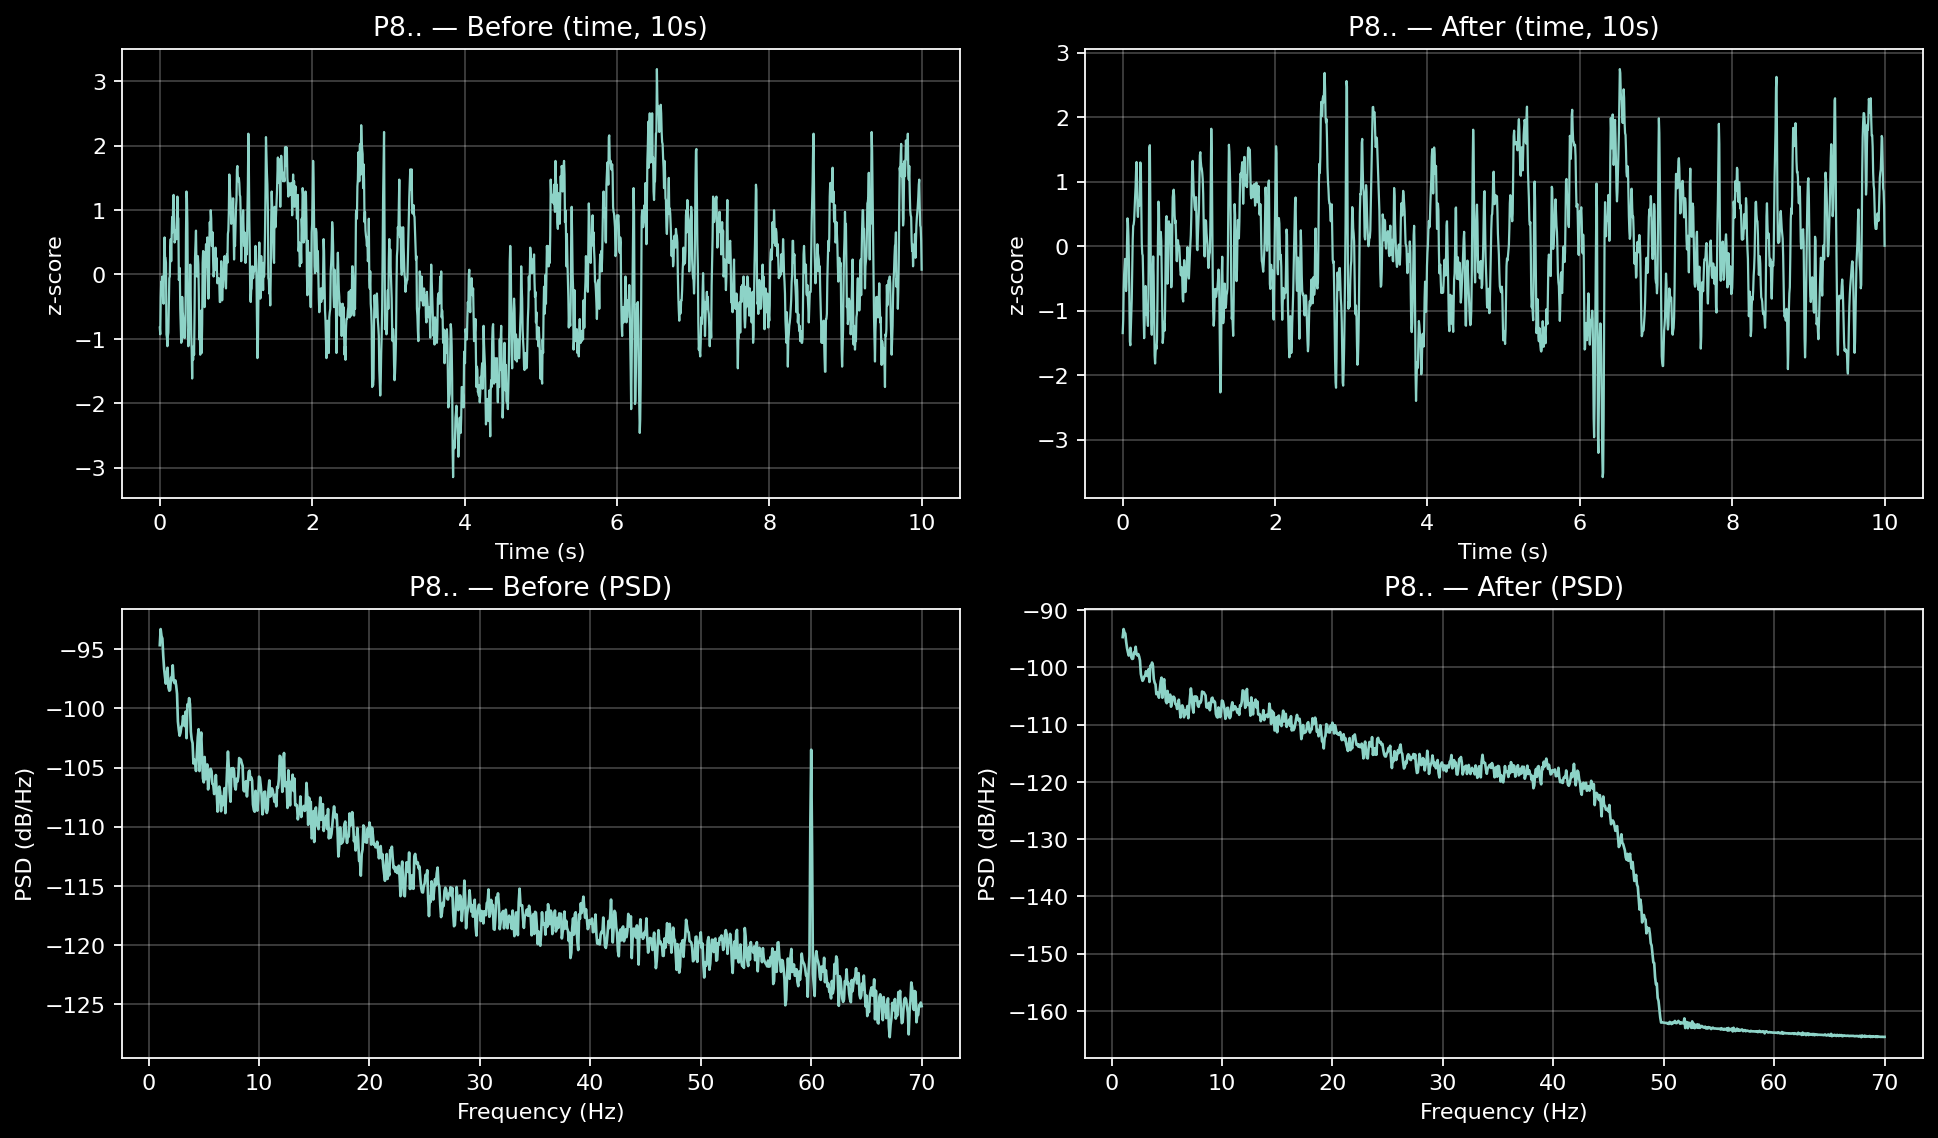

Saved figure       -> C:\Users\rjrie\Documents\neural_signal_db\processed\S001_run07\S001_run07_before_after_P8...png


In [7]:
# %% Pipeline: load → pick channel → filter → save → visualize

# 0) sanity checks
if not EDF_PATH.exists():
    raise FileNotFoundError(f"EDF not found: {EDF_PATH}")

# 1) Load raw
raw = read_edf_with_encoding_fallback(EDF_PATH, preload=True)
if len(mne.pick_types(raw.info, eeg=True)) == 0:
    raw = guess_types_by_name(raw)

if len(mne.pick_types(raw.info, eeg=True)) == 0:
    raise RuntimeError("No EEG channels available after type-guessing; cannot proceed.")

if MONTAGE:
    try:
        raw.set_montage(MONTAGE, on_missing="warn")
    except Exception as e:
        print("[WARN] montage not applied:", e)

# 2) pick channel
var_dict  = channel_variances_uV2(raw)
picked_ch = pick_eeg_channel(raw, var_dict, strategy=PICK_STRATEGY,
                             seed=RANDOM_SEED, ch_name=CH_NAME)
print("Picked channel:", picked_ch)

# 3) choose filters
if AUTO_NOTCH:
    notch_freqs = detect_mains_family(raw, fmin=1, fmax=70)
else:
    notch_freqs = MANUAL_NOTCH if MANUAL_NOTCH else []

l_freq, h_freq = BANDPASS
print(f"Filters → notch: {notch_freqs or 'none'}, bandpass: ({l_freq}, {h_freq}) Hz")

# 4) filter (with robust error handling)
raw_filt = raw.copy()
try:
    if notch_freqs:
        raw_filt.notch_filter(freqs=notch_freqs, picks="eeg", fir_design="firwin")
except Exception as e:
    print(f"[WARN] notch_filter failed ({e}); continuing without notch.")

try:
    raw_filt.filter(l_freq=l_freq, h_freq=h_freq, picks="eeg", fir_design="firwin")
except Exception as e:
    print(f"[WARN] band-pass filter failed ({e}); using unfiltered signal for 'after' view.")
    raw_filt = raw.copy()

# 5) save filtered run to processed/<stem>/<stem>_filt_raw.fif (+ JSON)
stem     = EDF_PATH.stem
out_dir  = (PROC_BASE / stem)
out_dir.mkdir(parents=True, exist_ok=True)

fif_path = out_dir / f"{stem}_filt_raw.fif"
raw_filt.save(fif_path, overwrite=True)

meta = {
    "source_edf": str(EDF_PATH),
    "picked_channel": picked_ch,
    "notch_freqs": notch_freqs,
    "bandpass": [l_freq, h_freq],
    "n_eeg_channels": int(len(mne.pick_types(raw.info, eeg=True))),
}
with open(out_dir / f"{stem}_filters.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved filtered FIF ->", fif_path)
print("Saved filter JSON  ->", out_dir / f"{stem}_filters.json")

# 6) BEFORE/AFTER inline figure (+ save PNG)
fig = make_before_after_fig(raw, raw_filt, picked_ch, seg_duration=10.0, fmin=1, fmax=70, dpi=160)
display(fig)

png_path = out_dir / f"{stem}_before_after_{picked_ch}.png"
fig.savefig(png_path, dpi=160, facecolor="black")
plt.close(fig)
print("Saved figure       ->", png_path)
